# Pygimli synthetic data study

## written by Anton Ziegon

<div class="alert alert-info">
<h4>Summary of this script</h4>

In this script forward calculations of geophysical methods are performed on the simple geologic model cross-section of a volcanic diatreme in a layered subsurface. The input model is the pygimli mesh ``mesh_combinedmodel.poly`` created in the Jupyter notebook ``RM_gempy_combined_model.ipynb``

In [11]:
# Importing pygimli
import  pygimli                 as     pg
import  pygimli.meshtools       as     mt
from    pygimli.physics         import ert

# Importing auxiliary libraries
import  numpy                   as     np
import  pandas                  as     pd
import  matplotlib.pyplot       as     plt
from    matplotlib.patches      import PathPatch 
import  os

plt.rcParams["figure.figsize"] = (10,10)
%matplotlib inline

# Setting options
np.random.seed(420)
pd.set_option('precision', 2)

## Parameter settings

In [12]:
# filenames
fname_mesh = 'mesh_combinedmodel.poly'

# Material properties
class Soil:
    rho = 100
    
class SS:
    rho = 1200
    
class CSS:
    rho = 3500
    
class basement:
    rho = 10**8
    
class Diatreme:
    rho = 10**5

## Loading model mesh

Text(1.5, 14.5, 'Diatreme')

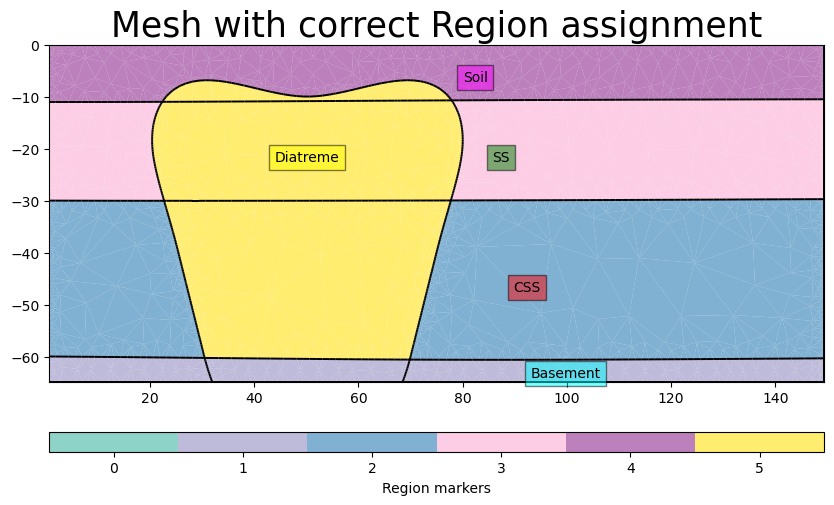

In [21]:
# Reading in saved model for QC
world = pg.meshtools.readPLC(fname_mesh)

# Adding RegionMarkers
# basement
world.addRegionMarker([10,-63], 1)
world.addRegionMarker([100,-63], 1)
world.addRegionMarker([35,-63], 1)
# CSS
world.addRegionMarker([10,-46], 2)
world.addRegionMarker([100,-46], 2)
# SS
world.addRegionMarker([10,-21], 3)
world.addRegionMarker([100,-21], 3)
# Soil
world.addRegionMarker([10,-6], 4)
# Diatreme
world.addRegionMarker([35,-46], 5)
world.addRegionMarker([35,-21], 5)
world.addRegionMarker([35,-9], 5)


fig, ax = plt.subplots()   
pg.show(world, ax=ax)
ax.set_title('Mesh with correct Region assignment', fontdict={'fontsize':25})
# Notes
plt.text(2.8, 18.5, 'Soil', horizontalalignment='center', bbox=dict(facecolor='magenta', alpha=0.5))
plt.text(3, 14.5, 'SS', horizontalalignment='center', bbox=dict(facecolor='green', alpha=0.5))
plt.text(3.2, 8, 'CSS', horizontalalignment='center', bbox=dict(facecolor='red', alpha=0.5))
plt.text(3.5, 3.7, 'Basement', horizontalalignment='center', bbox=dict(facecolor='cyan', alpha=0.5))
plt.text(1.5, 14.5, 'Diatreme', horizontalalignment='center', bbox=dict(facecolor='yellow', alpha=0.5))

### Mapping resistivity values to formations

06/12/22 - 18:12:27 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 0 within mesh.
06/12/22 - 18:12:27 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 1 within mesh.
06/12/22 - 18:12:27 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 2 within mesh.
06/12/22 - 18:12:27 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 3 within mesh.
06/12/22 - 18:12:27 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 4 within mesh.
06/12/22 - 18:12:27 - pyGIMLi - WARNING - parseMapToCellArray: cannot find marker 5 within mesh.


IndexError:  0 [0..0)
home/halbm/gimli/gimli/core/src/vector.h:584		const ValueType& GIMLI::Vector<ValueType>::getVal(GIMLI::Index) const [with ValueType = double; GIMLI::Index = long long unsigned int] 

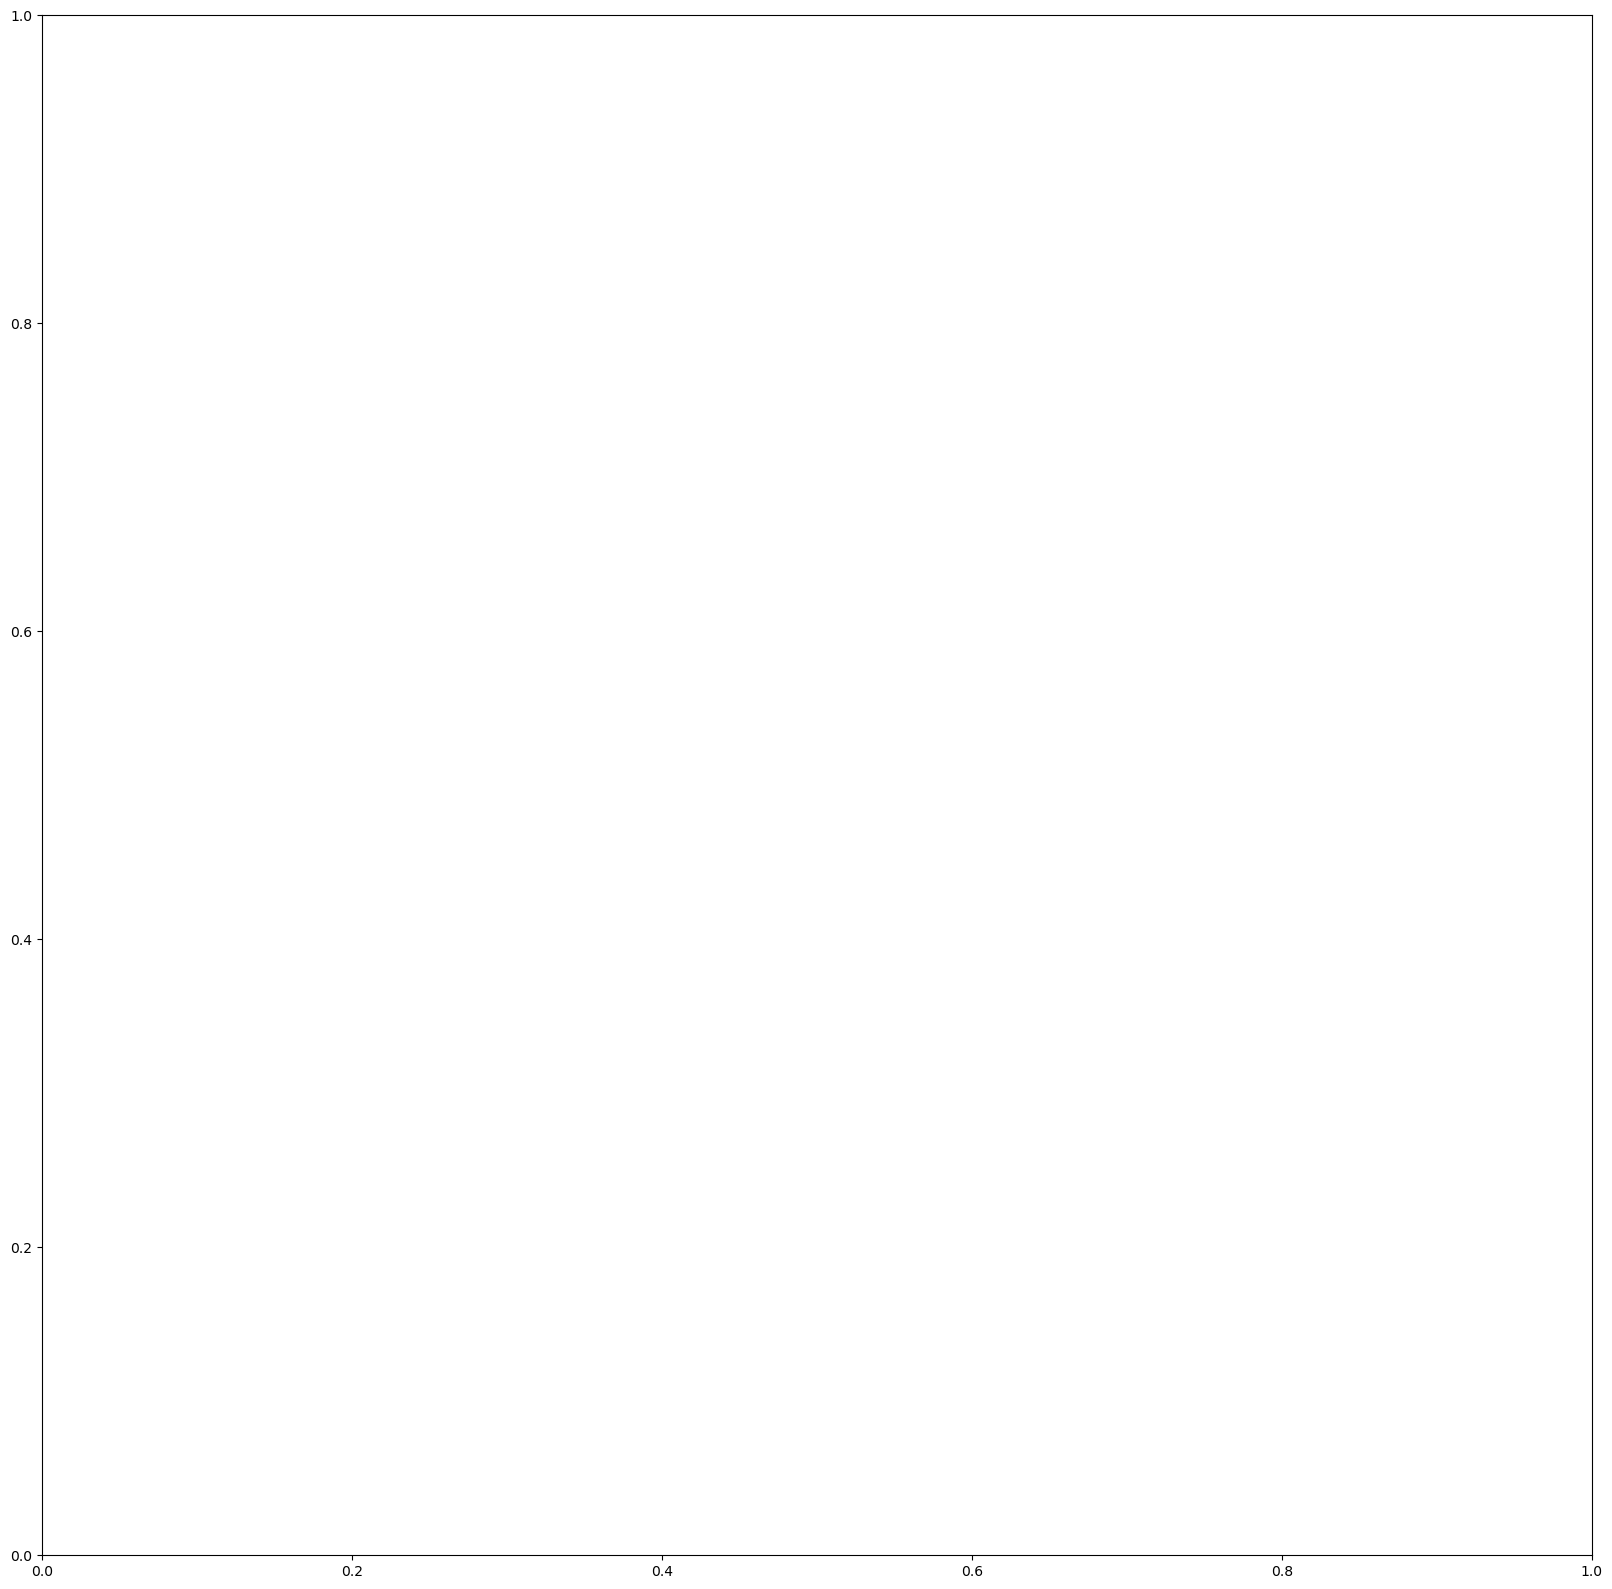

In [22]:
#Mapping typical resistance values to units
rhomap = [[0,1],[1,basement.rho], [2,CSS.rho], [3,SS.rho], [4,Soil.rho], [5,Diatreme.rho]]

#mesh = mt.createMesh(world)
fig, ax = plt.subplots(figsize=(20, 20))   
pg.show(world, ax=ax, data = rhomap, label = pg.unit('res'), colorBar =True)